In [1]:
import pandas as pd
import numpy as np
import random as rng
import time

import matplotlib.pyplot as plt

# Supporting
from schedule import Schedule
from paintshop import PaintShop,Source
from move import Move

from heuristics_constructive import Random
from heuristics_improvement import Annealing
from moveSelectionStrategy import MoveSelectionStrategies
from time import time

In [2]:
SEED = 420
rng.seed(SEED)
PS = PaintShop(Source.NOVEMBER)

[PaintShop] Loaded 'resources\PaintShop - November 2024.xlsx'


In [3]:
annealing = Annealing(100,0.9,100,1)

In [6]:
annealing = Annealing(100)

generator = Random(PS)
initial = generator.generate()
initial.plot(legend = True)

    |  0   1   2   3   4   5   6   7   8   9  10  11  12  | 9047.09 ✔
M1: |  0  21  24  42  26   7  30  15  27  33   6  32  44  | 3230.00 (36%)
M2: | 19   1   8   5   9  16  13  37  31   2  36  34  23  | 2603.50 (29%)
M3: |  3   4  12  22  40  39  25  10  20  17  38          | 2399.59 (27%)
M4: | 11  18  29  35  41  14  45  28  43                  | 814.00  (9%)
90.0
    |  0   1   2   3   4   5   6   7   8   9  10  11  12  | 6279.85 ✔
M1: |  0  21  24  10   7  30  15  18  27  41  39  44      | 1229.00 (20%)
M2: |  2  12  22  40  32  19  26  35  17  37  38  43  25  | 1658.50 (26%)
M3: |  1   8   5  11  16  13  31  28  36  34  23          | 1523.47 (24%)
M4: |  9   3   6  45  29  14  33  20   4  42              | 1868.88 (30%)
81.0
    |  0   1   2   3   4   5   6   7   8   9  10  11  | 4846.82 ✔
M1: |  4   0  24  10   7  15  33  38  21  39  25  44  | 935.00  (19%)
M2: |  2  12  40  32  19  26  35  17  37  43  30  41  | 1216.00 (25%)
M3: |  1   8   5  34  13  16  31  28  36  11  23     

In [4]:
from heuristics_improvement import HeuristicRunData


run_data = annealing.run_timed(
    HeuristicRunData(annealing, initial), 
    time(),
    60, # Runtime in seconds
    verbosity=1
)

[0.0] 0: [9106] swap: (0, 9) <=> (2, 4)
[0.2] 4: [9432] move: (2, 0) => (1, 4)
[0.3] 7: [8654] move: (0, 1) => (1, 9)
[0.4] 9: [8311] move: (0, 8) => (2, 7)
[0.6] 10: [8003] move: (0, 1) => (3, 2)
[0.7] 21: [8171] move: (0, 8) => (0, 4)
[0.8] 26: [8117] move: (1, 4) => (0, 3)
[0.8] 27: [8117] swap: (1, 9) <=> (2, 6)
[1.0] 36: [8065] move: (0, 11) => (2, 6)
[1.2] 39: [8053] move: (1, 5) => (0, 8)
[1.2] 42: [7767] move: (1, 11) => (3, 6)
[1.3] 44: [7861] swap: (0, 3) <=> (2, 3)
[1.3] 45: [7845] swap: (2, 3) <=> (2, 4)
[1.3] 47: [7473] move: (0, 1) => (1, 0)
[1.5] 55: [7441] swap: (2, 8) <=> (3, 9)
[1.5] 58: [7436] swap: (0, 8) <=> (3, 5)
[1.5] 59: [7378] move: (3, 9) => (2, 7)
[1.6] 62: [7285] move: (1, 10) => (3, 4)
[1.6] 65: [7276] move: (0, 10) => (1, 8)
[1.9] 73: [7173] move: (2, 7) => (0, 8)
[1.9] 74: [7110] swap: (1, 0) <=> (3, 1)
[1.9] 75: [6771] move: (0, 11) => (0, 0)
[2.0] 80: [6876] move: (0, 6) => (2, 10)
[2.0] 83: [6785] move: (1, 9) => (0, 7)
[2.1] 84: [6961] swap: (1, 3) <

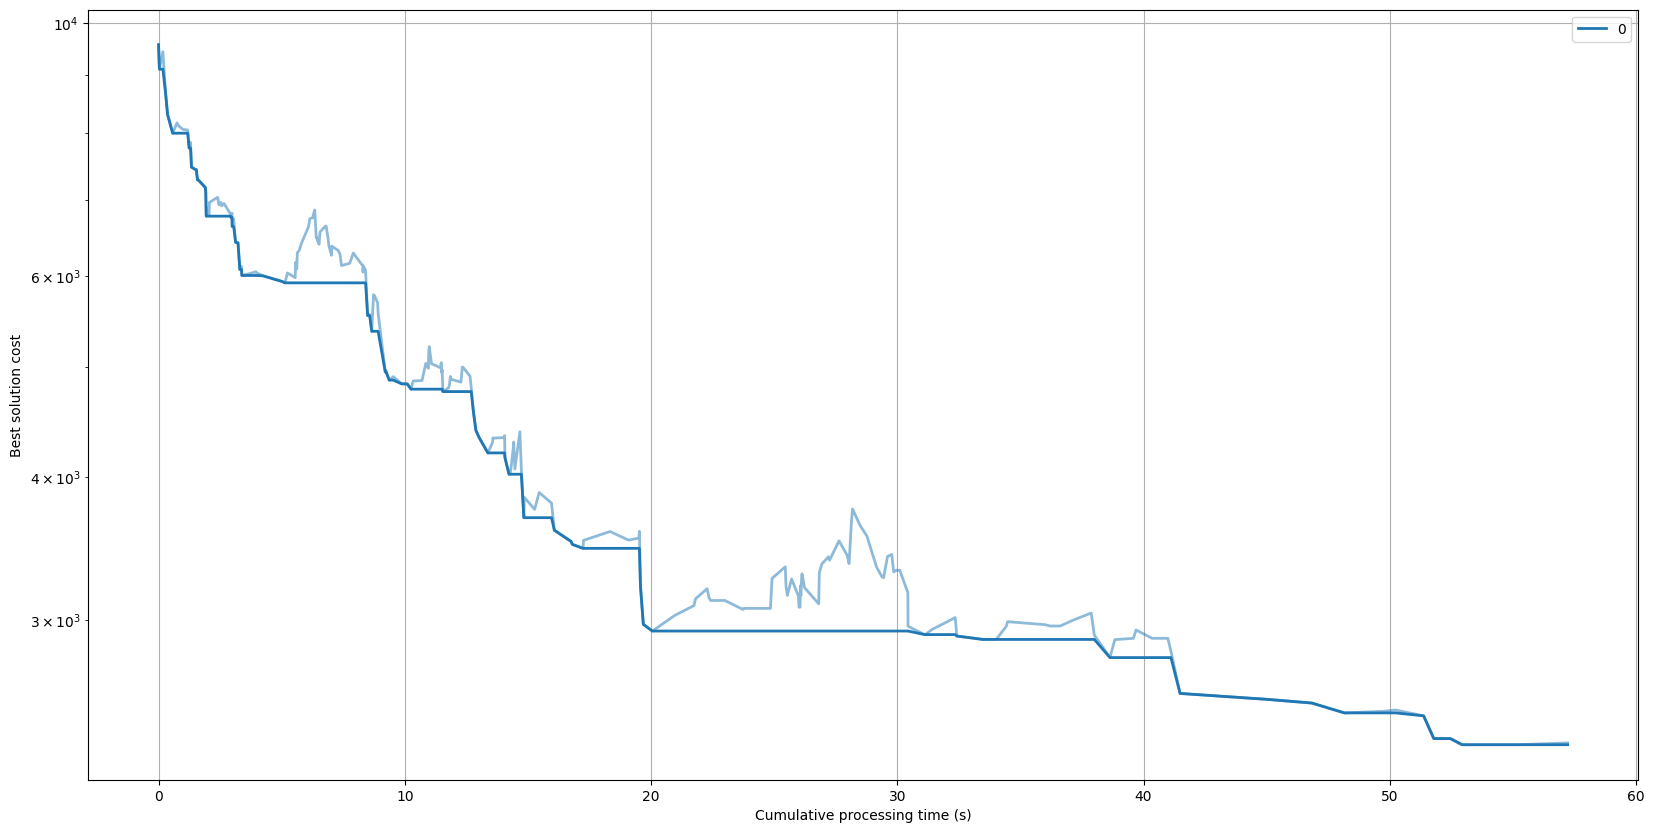

In [5]:
plt.figure(figsize=(20,10))

# Calculate running best
running_best_cost = []
for i in run_data.iterations:
    if len(running_best_cost) < 1 or i.cost < running_best_cost[-1]:
        running_best_cost.append(i.cost)
    else:
        running_best_cost.append(running_best_cost[-1])

# color = color=next(plt.gca()._get_lines.prop_cycler)['color']
line = plt.plot([iter.time for iter in run_data.iterations], [iter.cost for iter in run_data.iterations], linewidth = 2, alpha = .5)[0]
plt.plot([iter.time for iter in run_data.iterations], running_best_cost, linewidth = 2, alpha = 1, label = f'{0}', color = line.get_color())

plt.xlabel('Cumulative processing time (s)')
plt.ylabel('Best solution cost')
plt.grid()
plt.legend(loc = 'upper right')
plt.yscale('log')
# plt.xscale('log')asdasd
plt.show()

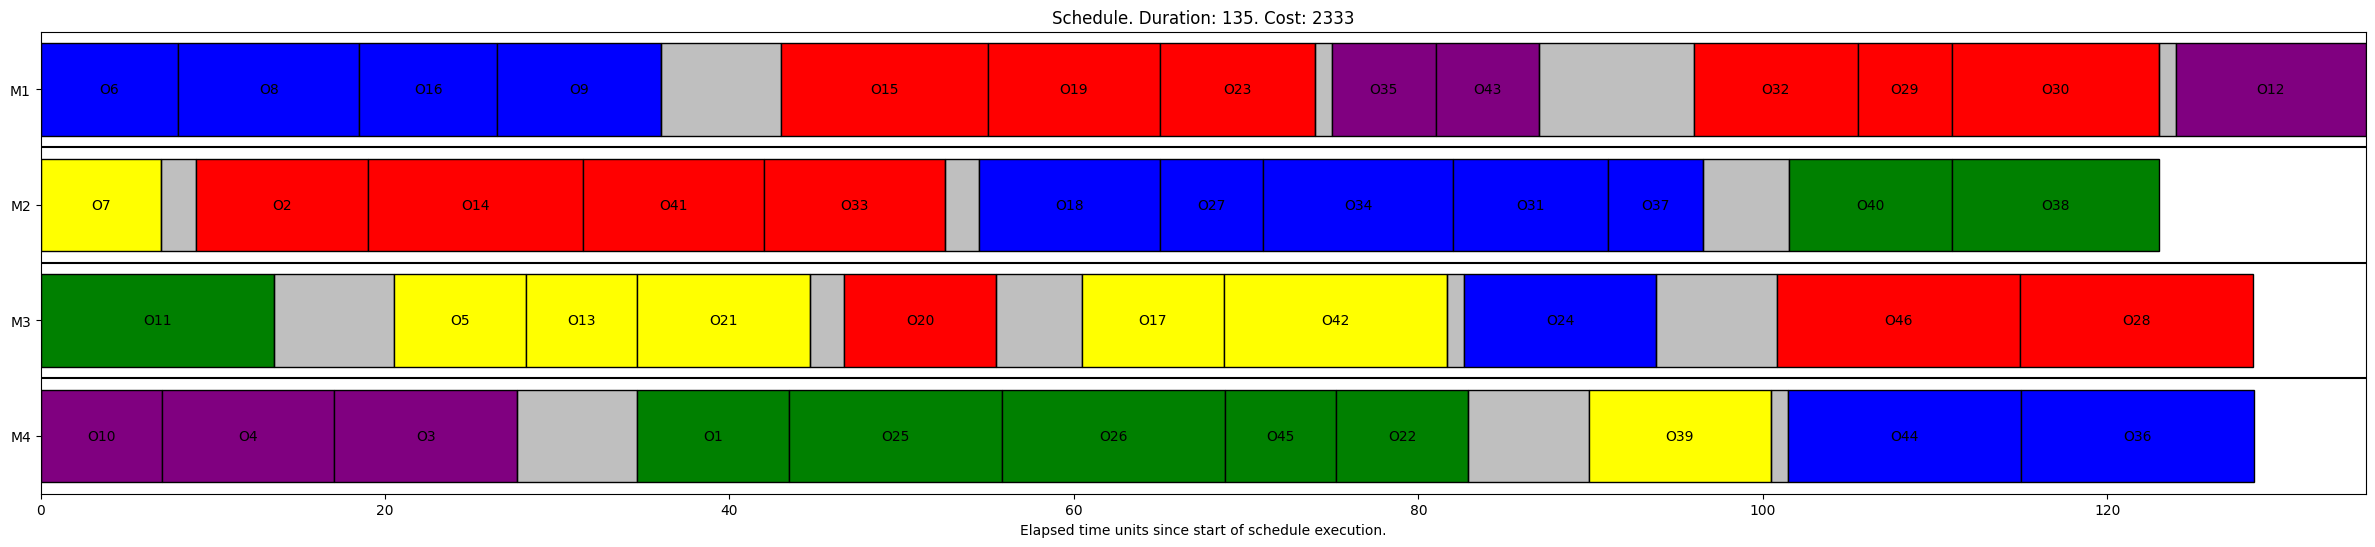

In [6]:
run_data.best.plot()

In [7]:
def setup_params(initial_temp,cool_rate,it_per_temp):
    return initial_temp, cool_rate, it_per_temp
def setup_schedule():
    return Random(PS).random.get_schedule()


In [8]:
def annealing_reheating(s,initial_temp,cool_rate,it_per_temp,end_temp,reheat_start,reheat_step,reheat_point):
    temp=initial_temp
    best=s
    reheat=reheat_start
    log_best=[]
    log_it=[]
    while temp > end_temp:
        for _ in range(it_per_temp):
            useless, moved=MoveSelectionStrategies.random.try_get_move(s)
            delta=moved.cost-s.cost
            if delta < 0 or rng.random() < np.exp(-delta/temp):
                s=moved
                if s.cost < best.cost:
                    best=s
            log_best+=[best.cost]
            log_it+=[s.cost]
        temp*=cool_rate
        print(s)
        print(temp)
        if temp < reheat_point:
            temp=reheat
            reheat-=reheat_step
    print(best)
    return (log_best, log_it,best)


In [9]:
s=setup_schedule()
print(s)
temp=50
moved=MoveSelectionStrategies.random.try_get_move(s)
print(moved)
delta=moved.cost-s.cost
rnd = rng.random()
if delta <0 or rnd < np.exp(-delta/temp):
    s=moved
print(delta,f'improving move? {delta<0}')
print(rnd,'<',np.exp(-delta/temp),np.exp(delta/temp),rnd<np.exp(-delta/temp))
print(delta <0 or rnd < np.exp(-delta/temp))
print(s)

AttributeError: 'Random' object has no attribute 'random'

In [19]:
s=setup_schedule()
for _ in range(100):
    move,s=MoveSelectionStrategies.random.try_get_move(s)
    print(s)

TypeError: 'int' object is not subscriptable

In [13]:
s=setup_schedule()
log_best,log_it,best=annealing(s,1000,0.9,1000,1)

    |  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  | 16403.62 ✔
M1: | 23  24  33  27  19   9  35  20  34  30   7   3  12   5      | 7331.50 (45%)
M2: | 10  17  15  22   8  36  16   6  42  32  25  41  29  28  21  | 5262.00 (32%)
M3: |  4   1  13  18   0  38   2  40  39  37  26  11              | 3810.12 (23%)
M4: | 44  45  14  43  31                                          | 0.00    (0%)
900.0
    |  0   1   2   3   4   5   6   7   8   9  10  11  12  13  | 13415.18 ✔
M1: |  5  35  16   3   6  18  13  12  45  31                  | 2055.00 (15%)
M2: |  8   4  43  29  40  19   1  11  23  27  17  20  36      | 3688.00 (27%)
M3: | 10  41  34  15  28  26  30   0  14                      | 1356.59 (10%)
M4: | 33  24  32  39   9  37  25  42   2   7  22  38  44  21  | 6315.59 (47%)
810.0
    |  0   1   2   3   4   5   6   7   8   9  10  11  12  | 11365.79 ✔
M1: | 30   2   8   9  21  41  44  37   0  36  29          | 1263.50 (11%)
M2: | 13   4  39  15  14  43  26  45  18  10  38  

In [9]:
s=setup_schedule()
log_best,log_it,best=annealing_reheating(s,1000,0.9,500,0.5,100,10,2)

    |  0   1   2   3   4   5   6   7   8   9  10  11  12  | 6747.60 ✔
M1: | 12  13   4  27  22  29   7  15  11   3   2          | 2958.00 (44%)
M2: | 26   6   0  10  18   1  23   8  24   5  28  17  16  | 3397.60 (50%)
M3: | 25  20  14  19  21   9                              | 392.00  (6%)
900.0
    |  0   1   2   3   4   5   6   7   8   9  10  11  12  13  | 8473.14 ✔
M1: |  7   1  26   0   8   2                                  | 699.50  (8%)
M2: | 18  14   5  24  21  17  27   9  12   3  22  16  13  23  | 4326.20 (51%)
M3: | 15  25   6   4  29  10  28  11  20  19                  | 3447.44 (41%)
810.0
    |  0   1   2   3   4   5   6   7   8   9  10  11  | 8253.81 ✔
M1: | 25  16   9  27  23  20   4  11   6  18  22  15  | 4258.50 (52%)
M2: |  1   0   2   8  29  26  10  21                  | 655.20  (8%)
M3: | 12   5  13   7   3  14  17  28  24  19          | 3340.11 (40%)
729.0
    |  0   1   2   3   4   5   6   7   8   9  10  | 8525.76 ✔
M1: | 25  14  22  10   7  27   4   3  29  28   

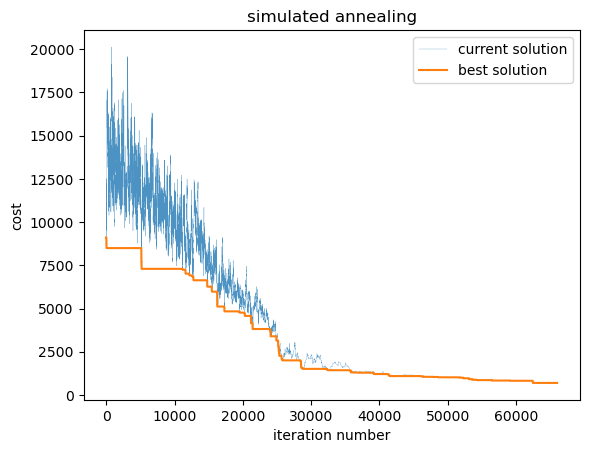

In [14]:
plt.plot(range(1,len(log_it)+1),log_it,label='current solution',linewidth=0.2,alpha=0.8)
plt.plot(range(1,len(log_best)+1),log_best,label='best solution')
plt.xlabel('iteration number')
plt.ylabel('cost')
plt.title('simulated annealing')
plt.legend()
plt.show()